<a href="https://colab.research.google.com/github/OUCTheoryGroup/colab_demo/blob/master/06_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 自编码器 Autoencoder

大家都学习过理论知识，应该对于自编码器比较了解了

下面我们还是结合代码来学习。首先引入基本的库，然后定义了两个后面要使用的函数

In [0]:
# Import some libraries
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

# 把输入数据由向量转化为图像
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

# 显示图像
def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(6, 2))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N], 'gray')
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(6, 2))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N], 'gray')
            plt.axis('off')

## 1. 加载数据

In [0]:
# 每次加载数据的 batch_size，即每次加载256张图像
batch_size = 256

# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

## 2. 标准自编码器

下面代码非常简单，可以看到 Standard AE 输入是 784 维向量，然后中间层有30个节点，然一输入 784 维向量。

In [0]:
d = 30 

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#模型放到GPU上，同时定义损失函数和优化器
model = Autoencoder().to(device)
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

下面我们进入模型训练步骤，这里我们跑 3 个 epoch，每轮训练结束，输出一下原图像，以及重建结果。

epoch [1/3], loss:0.2129
epoch [2/3], loss:0.1656
epoch [3/3], loss:0.1378


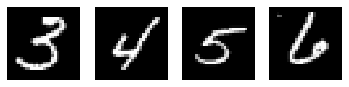

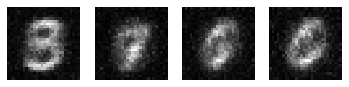

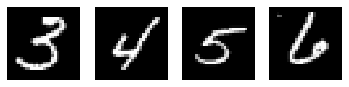

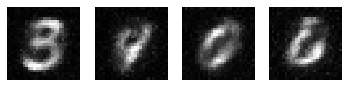

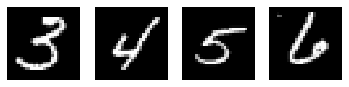

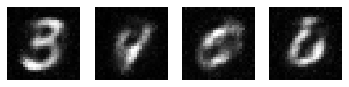

In [4]:
num_epochs = 3
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        img.requires_grad_()
        img = img.view(img.size(0), -1)
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(img, output) 

从上面的输出中，我们可以看出，重建的 loss 在下降，因此，从重建的结果来看，基本的轮廓重建较好，但细节有所损失。3 个 epoch 已经看到明显的效果改进，感兴趣的同学可以把epoch改大，多跑几轮，看看效果。

## 3. 降噪自编码器

下面我们看看降噪自编码器的效果如何。它的特点是，输入的数据是 bad_img，即损坏了的图像；另外，中间层的节点数量会更多一些。

In [0]:
d = 500  # d 的值由30涨到了500

class Denoising_Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
DenosingAE_model = Denoising_Autoencoder().to(device)
criterion = nn.MSELoss()
learning_rate = 1e-3
DenosingAE_optimizer = torch.optim.Adam(DenosingAE_model.parameters(), lr=learning_rate)

模型训练步骤，仍然是跑 3 个 epoch，每轮训练结束，输出原图像，以及重建结果。

和上面的代码不同的是，使用 nn.Dropout 函数，随机丢弃原图像中的像素，增加重建的难度。

epoch [1/3], loss:0.0250
epoch [2/3], loss:0.0107
epoch [3/3], loss:0.0078


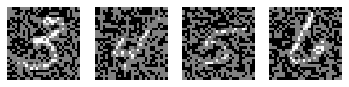

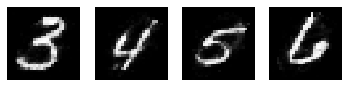

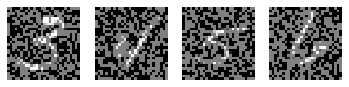

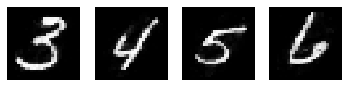

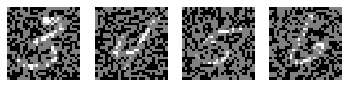

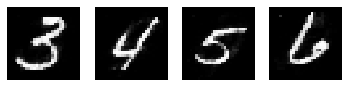

In [6]:
num_epochs = 3
# 用来丢弃图像中的像素
do = nn.Dropout()  
for epoch in range(num_epochs):
    for data in dataloader:
        img = img.to(device)
        img.requires_grad_()
        img = img.view(img.size(0), -1)
        # 随机丢弃图像中的一些像素
        noise = do(torch.ones(img.shape)).to(device)
        img_bad = (img * noise).to(device)
        # ===================forward=====================
        output = DenosingAE_model(img_bad) # 这里输入的是 img_bad 
        loss = criterion(output, img.data)
        # ===================backward====================
        DenosingAE_optimizer.zero_grad()
        loss.backward()
        DenosingAE_optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(img_bad, output)

从 denosing Autoencoder 的示例可以看出，即使输入的是损坏的图像，重建的效果仍然非常好。具体原因大家可以自己思考。